In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import sys
import seaborn as sns
sns.set()
sns.set_style("whitegrid",  {"grid.linewidth": 0.6})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
ls=20
fs=30
show=True
save=False
lw=4

## Derivatives

In [3]:
# The objective function is f(x, y) = L(xy)+L(0) where L(t)=-log(1+exp(-t))
def f(x, y):
    return -np.log(1+np.exp(-x*y))

# Derivative of L(x)
def fp(x):
    return 1/(1+np.exp(x))

# 2nd derivative of L(x)
def fp2(x):
    return -np.exp(x)/(1+np.exp(x))**2

def d1f_func(x, y):
    return y*fp(x*y)

def d2f_func(x, y):
    return x*fp(x*y)

def d11f_func(x, y):
    return y**2*fp2(x*y)

def d22f_func(x, y):
    return x**2*fp2(x*y) 

def d12f_func(x, y):
    return x*y*fp2(x*y)+fp(x*y)

## Dynamics

In [4]:
def run_sim_dynamics(x=1, y=1, learning_rate=0.01, num_its=5000):

    trajectory = []
    trajectory.append(np.array([x, y]))

    for it in range(1, num_its+1):

        d1f = d1f_func(x, y)             
        d2f = d2f_func(x, y)
        x = x - learning_rate * d1f
        y = y + learning_rate * d2f
        trajectory.append(np.array([x, y]))

    trajectory = np.array(trajectory)

    return trajectory

def run_alt_dynamics(x=1, y=1, learning_rate=0.01, num_its=5000, k=10):

    trajectory = []
    trajectory.append(np.array([x, y]))

    for it in range(1, num_its+1):
        for inner in range(k):
            d2f = d2f_func(x, y)
            y = y + learning_rate * d2f
            
        d1f = d1f_func(x, y)             
        x = x - learning_rate * d1f
        trajectory.append(np.array([x, y]))

    trajectory = np.array(trajectory)

    return trajectory

def run_unroll_dynamics(x=1, sample_range_start=-.1, sample_range_end=.1, learning_rate=0.01, num_its=20000, k=10, higher=True):

    trajectory = []

    for it in range(1, num_its+1):
        y = np.random.uniform(sample_range_start, sample_range_end)
        da = 0
        for inner in range(k):            
            d2f = d2f_func(x, y)
            da = (1+learning_rate*d22f_func(x, y))*da + learning_rate*d12f_func(x, y)
            y = y + learning_rate * d2f

        d1f = d1f_func(x, y) 
        d2f = d2f_func(x, y)
        if higher:
            x = x - learning_rate*(d1f+da*d2f)
        else:
            x = x - learning_rate*d1f
        
        trajectory.append(np.array([x, y]))

    trajectory = np.array(trajectory)

    return trajectory

In [13]:
save=True
np.random.seed(0)
window=1
plot_cost = False
running_mean = lambda x: np.cumsum(x)/np.arange(1, len(x)+1)
figsize = (8, 5)

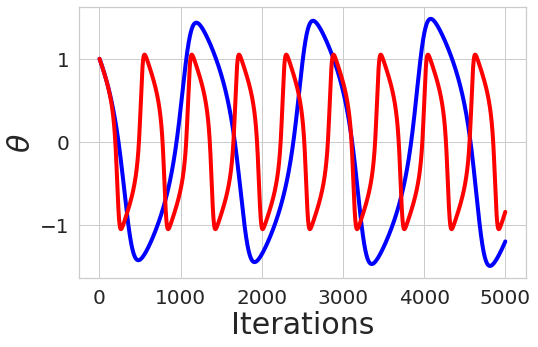

In [14]:
np.random.seed(0)
traj_sim = run_sim_dynamics()
traj_alt = run_alt_dynamics()

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(traj_sim[:, 0], color='blue', lw=lw)
ax.plot(traj_alt[:, 0], color='red', lw=lw)
ax.tick_params(labelsize=ls)
ax.set_ylabel(r'$\theta$', fontsize=fs)
ax.set_xlabel(r'Iterations', fontsize=fs)
if save:
    plt.savefig(os.path.join(os.getcwd(), 'simgrad_altgrad.png'), bbox_inches='tight')
plt.show()

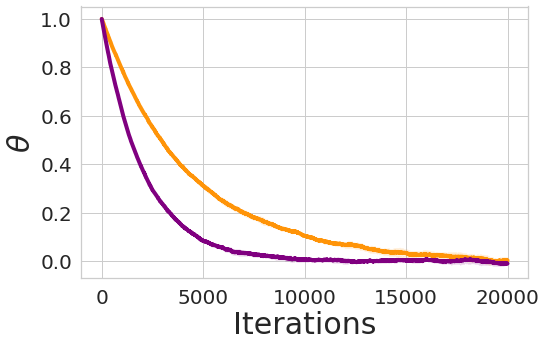

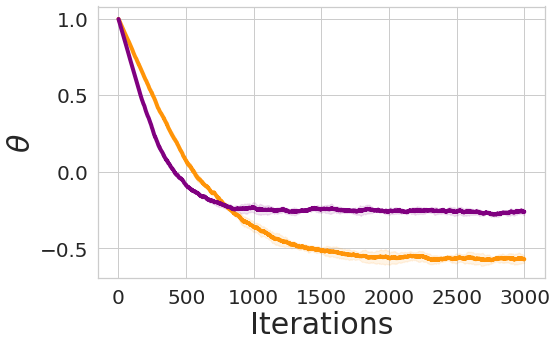

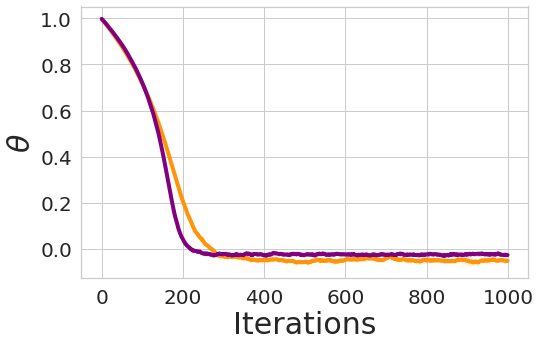

In [16]:
param_sets = []

sample_range_start=-.1
sample_range_end=.1
num_its=20000 
k=10
param_sets.append((sample_range_start, sample_range_end, num_its, k))

sample_range_start=-.5
sample_range_end=1
num_its=3000
k=100
param_sets.append((sample_range_start, sample_range_end, num_its, k))

sample_range_start=-.5
sample_range_end=1
num_its=1000 
k=1000
param_sets.append((sample_range_start, sample_range_end, num_its, k))

for count, param_set in enumerate(param_sets):
    sample_range_start, sample_range_end, num_its, k = param_set
    traj_unroll_list = []
    traj_unroll_higher_list = []
    for seed in range(5):
        np.random.seed(seed)
        traj_unroll = run_unroll_dynamics(higher=False, sample_range_start=sample_range_start, 
                                          sample_range_end=sample_range_end, num_its=num_its, k=k)
        traj_unroll_higher = run_unroll_dynamics(higher=True, sample_range_start=sample_range_start, 
                                          sample_range_end=sample_range_end, num_its=num_its, k=k)
        traj_unroll_list.append(traj_unroll[:, 0])
        traj_unroll_higher_list.append(traj_unroll_higher[:, 0])

    traj_unroll = np.vstack(traj_unroll_list)
    traj_unroll_higher = np.vstack(traj_unroll_higher_list)

    traj_unroll_mean = np.mean(traj_unroll, axis=0)
    traj_unroll_std = np.std(traj_unroll, axis=0)

    traj_unroll_higher_mean = np.mean(traj_unroll_higher, axis=0)
    traj_unroll_higher_std = np.std(traj_unroll_higher, axis=0)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(traj_unroll_mean, color='xkcd:tangerine', lw=lw)
    ax.fill_between(range(len(traj_unroll_mean)), traj_unroll_mean-traj_unroll_std, 
                    traj_unroll_mean+traj_unroll_std, color='xkcd:tangerine', alpha=.1)

    ax.plot(traj_unroll_higher_mean, color='purple', lw=lw)
    ax.fill_between(range(len(traj_unroll_higher_mean)), traj_unroll_higher_mean-traj_unroll_higher_std, 
                    traj_unroll_higher_mean+traj_unroll_higher_std, color='purple', alpha=.1)

    ax.tick_params(labelsize=ls)
    ax.set_ylabel(r'$\theta$', fontsize=fs)
    ax.set_xlabel(r'Iterations', fontsize=fs)
    if save:
        plt.savefig(os.path.join(os.getcwd(), 'param_sets' + str(count)+'.png'), bbox_inches='tight')
    plt.show()